In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv("/content/drive/My Drive/jena_climate_2009_2016.csv", parse_dates = ['Date Time'], index_col='Date Time')

In [4]:
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
data['hour'] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month

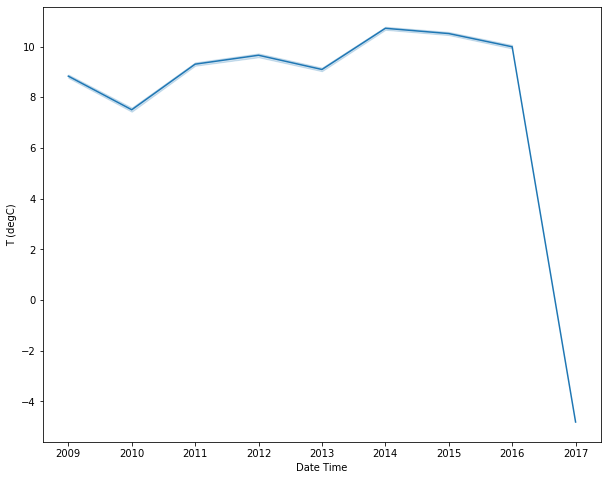

In [6]:
plt.figure(figsize=(10,8))
sns.lineplot(x=data.index.year , y='T (degC)' , data = data)

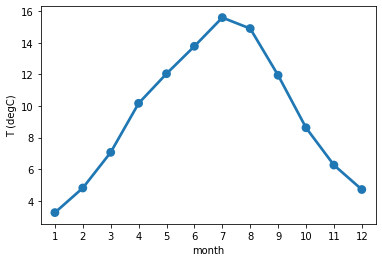

In [7]:
sns.pointplot(x='month' , data = data , y='T (degC)')

In [8]:
train_size = int(0.9*len(data))
test_size = len(data) - train_size
train , test = data[:train_size] , data[train_size : len(data)]
print(train.shape , test.shape)

(378495, 17) (42056, 17)


In [9]:
from sklearn.preprocessing import RobustScaler

scaler_1 = RobustScaler()
scaler_2 = RobustScaler()

cols = []
for c in data.columns:
    if c not in ['hour' , 'month' , 'day','T (degC)']:
        cols.append(c)
        
scaler_1= scaler_1.fit(train[cols].values)
scaler_2 = scaler_2.fit(train[['T (degC)']].values)

train[cols] = scaler_1.transform(train[cols])
train['T (degC)'] = scaler_2.transform(train[['T (degC)']])

test[cols] = scaler_1.transform(test[cols])
test['T (degC)'] = scaler_2.transform(test[['T (degC)']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [10]:
def create_dataset(X , y , timesteps):
    Xs , ys = [] ,[]
    for i in range(len(X)-timesteps):
        val = X.iloc[i:(i+timesteps)].values
        Xs.append(val)
        ys.append(y.iloc[i+timesteps].values)
        
    return np.array(Xs) , np.array(ys)    

In [11]:
# Colab is crashing 
train = train[200000:]

In [12]:
train.shape

(178495, 17)

In [13]:
timesteps = 144
X_train , y_train = create_dataset(train , train[['T (degC)']] , timesteps)

In [14]:
print(X_train.shape , y_train.shape)

(178351, 144, 17) (178351, 1)


In [15]:
X_test , y_test = create_dataset(test , test[['T (degC)']] , timesteps)

In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Dropout , LSTM , Bidirectional

In [17]:
model = Sequential()
model.add(LSTM(units = 128 , return_sequences = True , input_shape = (X_train.shape[1] , X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam' , loss = 'mean_squared_error')

In [18]:
history = model.fit(X_train , y_train,
                   epochs = 4 , 
                   batch_size = 144, 
                   validation_split = 0.1,
                   shuffle = False)

Epoch 1/4
1115/1115 [==============================] - 22s 20ms/step - loss: 0.0713 - val_loss: 0.0383
Epoch 2/4
1115/1115 [==============================] - 21s 19ms/step - loss: 0.0235 - val_loss: 0.0089
Epoch 3/4
1115/1115 [==============================] - 22s 20ms/step - loss: 0.0135 - val_loss: 0.0080
Epoch 4/4
1115/1115 [==============================] - 22s 20ms/step - loss: 0.0107 - val_loss: 0.0046


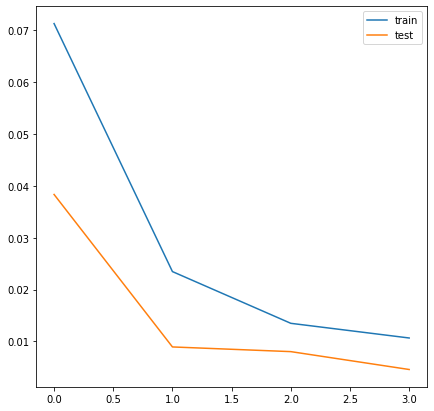

In [19]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'] , label = 'train')
plt.plot(history.history['val_loss'] , label='test')
plt.legend()

In [20]:
test.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),hour,day,month
Date Time,,,,,,,,,,,,,,,,,
2016-11-03 20:40:00,1.212264,-0.524712,-0.617039,-0.437755,0.275000,-0.429752,-0.379768,-0.25058,-0.395806,-0.395082,0.862738,1.042553,0.723906,-1.573777,20,3,11
2016-11-03 20:50:00,1.218868,-0.524712,-0.617039,-0.438776,0.270833,-0.429752,-0.381426,-0.25058,-0.398427,-0.396721,0.864370,0.893617,0.515152,-1.586057,20,3,11
2016-11-03 21:00:00,1.222642,-0.528830,-0.622002,-0.440816,0.279167,-0.431818,-0.383085,-0.25290,-0.398427,-0.396721,0.869628,0.643617,0.744108,-1.659187,21,3,11
2016-11-03 21:10:00,1.232075,-0.530478,-0.624483,-0.444898,0.275000,-0.432851,-0.384743,-0.25290,-0.401048,-0.400000,0.873617,0.792553,0.932660,-1.604063,21,3,11
2016-11-03 21:20:00,1.234906,-0.535420,-0.629446,-0.454082,0.266667,-0.436983,-0.393035,-0.25058,-0.408912,-0.406557,0.879601,1.021277,1.026936,-1.599354,21,3,11


In [21]:
X_test , y_test = create_dataset(test , test[['T (degC)']] , timesteps)
y_pred = model.predict(X_test)

In [22]:
y_test_inv = scaler_2.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_2.inverse_transform(y_pred)
y_train_inv = scaler_2.inverse_transform(y_train.reshape(-1,1))

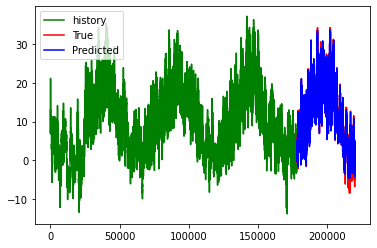

In [23]:
#plt.figure(figsize=(14,8))
plt.plot(np.arange(0,len(y_train)) , y_train_inv.flatten(),'g' , label = 'history')

plt.plot(np.arange(len(y_train) , len(y_train)+len(y_test)) , y_test_inv.flatten(), 'r' , label = 'True' )
plt.plot(np.arange(len(y_train) , len(y_train)+len(y_test)) , y_pred_inv.flatten(), 'b' , label = 'Predicted' )

plt.legend()

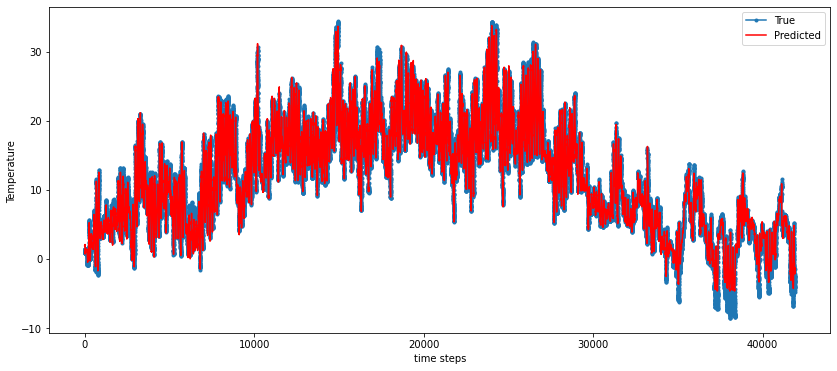

In [26]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv.flatten() , marker = '.' , label = 'True')
plt.plot(y_pred_inv.flatten() , 'r' , label = 'Predicted')
plt.ylabel('Temperature ')
plt.xlabel("time steps")
plt.legend()
plt.show();